In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline


In [27]:
# Set random seed for reproducibility
np.random.seed(42)

In [28]:
# Load the Breast Cancer dataset (binary classification)
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

In [29]:
print("Dataset shape:", X.shape)
print("Features:", X.shape[1])
print("Classes:", np.unique(y))
print("Class distribution:")
for class_value, count in zip(*np.unique(y, return_counts=True)):
    class_name = 'Malignant' if class_value == 0 else 'Benign'
    print(f"  - Class {class_value} ({class_name}): {count} ({count/len(y):.2%})")

Dataset shape: (569, 30)
Features: 30
Classes: [0 1]
Class distribution:
  - Class 0 (Malignant): 212 (37.26%)
  - Class 1 (Benign): 357 (62.74%)


In [30]:
# 1. Basic Stratified K-fold cross-validation
def stratified_kfold_cv_basic(X, y, model, n_splits=5):
    """
    Perform basic stratified k-fold cross-validation and return scores.
    """
    # Create the StratifiedKFold object
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize lists to store metrics for each fold
    fold_accuracy = []
    fold_precision = []
    fold_recall = []
    fold_f1 = []

    print(f"\nPerforming Stratified {n_splits}-fold cross-validation...")

    # Loop through each fold
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Check class distribution in this fold
        train_class_dist = np.bincount(y_train) / len(y_train)
        test_class_dist = np.bincount(y_test) / len(y_test)

        print(f"\nFold {fold+1}:")
        print(f"  Training set class distribution: Malignant {train_class_dist[0]:.2%}, Benign {train_class_dist[1]:.2%}")
        print(f"  Test set class distribution: Malignant {test_class_dist[0]:.2%}, Benign {test_class_dist[1]:.2%}")

        # Preprocess the data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train the model
        model.fit(X_train_scaled, y_train)

        # Make predictions
        y_pred = model.predict(X_test_scaled)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Store metrics
        fold_accuracy.append(accuracy)
        fold_precision.append(precision)
        fold_recall.append(recall)
        fold_f1.append(f1)

        # Print fold results
        print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # Calculate and print average scores
    print("\nAverage scores across all folds:")
    print(f"  Accuracy: {np.mean(fold_accuracy):.4f} (±{np.std(fold_accuracy):.4f})")
    print(f"  Precision: {np.mean(fold_precision):.4f} (±{np.std(fold_precision):.4f})")
    print(f"  Recall: {np.mean(fold_recall):.4f} (±{np.std(fold_recall):.4f})")
    print(f"  F1 Score: {np.mean(fold_f1):.4f} (±{np.std(fold_f1):.4f})")

    return {
        'accuracy': fold_accuracy,
        'precision': fold_precision,
        'recall': fold_recall,
        'f1': fold_f1
    }


In [31]:
# Let's try with a Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_scores = stratified_kfold_cv_basic(X, y, lr_model, n_splits=5)


Performing Stratified 5-fold cross-validation...

Fold 1:
  Training set class distribution: Malignant 37.14%, Benign 62.86%
  Test set class distribution: Malignant 37.72%, Benign 62.28%
  Accuracy: 0.9737, Precision: 0.9857, Recall: 0.9718, F1: 0.9787

Fold 2:
  Training set class distribution: Malignant 37.14%, Benign 62.86%
  Test set class distribution: Malignant 37.72%, Benign 62.28%
  Accuracy: 0.9474, Precision: 0.9221, Recall: 1.0000, F1: 0.9595

Fold 3:
  Training set class distribution: Malignant 37.36%, Benign 62.64%
  Test set class distribution: Malignant 36.84%, Benign 63.16%
  Accuracy: 0.9649, Precision: 0.9474, Recall: 1.0000, F1: 0.9730

Fold 4:
  Training set class distribution: Malignant 37.36%, Benign 62.64%
  Test set class distribution: Malignant 36.84%, Benign 63.16%
  Accuracy: 0.9912, Precision: 1.0000, Recall: 0.9861, F1: 0.9930

Fold 5:
  Training set class distribution: Malignant 37.28%, Benign 62.72%
  Test set class distribution: Malignant 37.17%, Benig

In [32]:
# 2. Comparing multiple models with Stratified K-fold
def compare_models_stratified_kfold(X, y, models, n_splits=5):
    """
    Compare multiple models using stratified k-fold cross-validation.
    """
    results = {}
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    for name, model in models.items():
        print(f"\n{'-'*60}")
        print(f"Evaluating: {name}")

        # Create a pipeline with scaling and the model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        # Create StratifiedKFold object
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        # Use scikit-learn's cross_val_score for each metric
        results[name] = {}

        for metric in metrics:
            scoring = metric if metric != 'precision' else 'precision_macro'
            scores = cross_val_score(pipeline, X, y,
                                   scoring=scoring,
                                   cv=skf, n_jobs=-1)

            results[name][metric] = scores
            print(f"{metric.capitalize()}: {np.mean(scores):.4f} (±{np.std(scores):.4f})")

    return results


In [33]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

In [34]:
# Compare models
results = compare_models_stratified_kfold(X, y, models, n_splits=5)



------------------------------------------------------------
Evaluating: Logistic Regression
Accuracy: 0.9737 (±0.0166)
Precision: 0.9773 (±0.0118)
Recall: 0.9916 (±0.0112)
F1: 0.9794 (±0.0127)

------------------------------------------------------------
Evaluating: Random Forest
Accuracy: 0.9561 (±0.0123)
Precision: 0.9557 (±0.0124)
Recall: 0.9665 (±0.0272)
F1: 0.9651 (±0.0097)

------------------------------------------------------------
Evaluating: SVM
Accuracy: 0.9772 (±0.0163)
Precision: 0.9783 (±0.0154)
Recall: 0.9888 (±0.0105)
F1: 0.9820 (±0.0128)


In [35]:
# 3. Visualize stratified cross-validation results
def plot_stratified_cv_results(results):
    """
    Plot the stratified cross-validation results for easy comparison.
    """
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    model_names = list(results.keys())
    colors = ['blue', 'green', 'red', 'purple', 'orange'][:len(model_names)]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]

        for j, model in enumerate(model_names):
            metric_data = results[model][metric]
            ax.bar(j, np.mean(metric_data), yerr=np.std(metric_data),
                  capsize=10, color=colors[j], alpha=0.7,
                  label=f"{model} ({np.mean(metric_data):.4f})")

        ax.set_xticks(range(len(model_names)))
        ax.set_xticklabels(model_names, rotation=45, ha='right')
        ax.set_ylabel(f'{metric.capitalize()} Score')
        ax.set_title(f'Stratified CV {metric.capitalize()} by Model')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        if i == 0:  # Only add legend to the first plot
            ax.legend(loc='best')

    plt.tight_layout()
    plt.show()


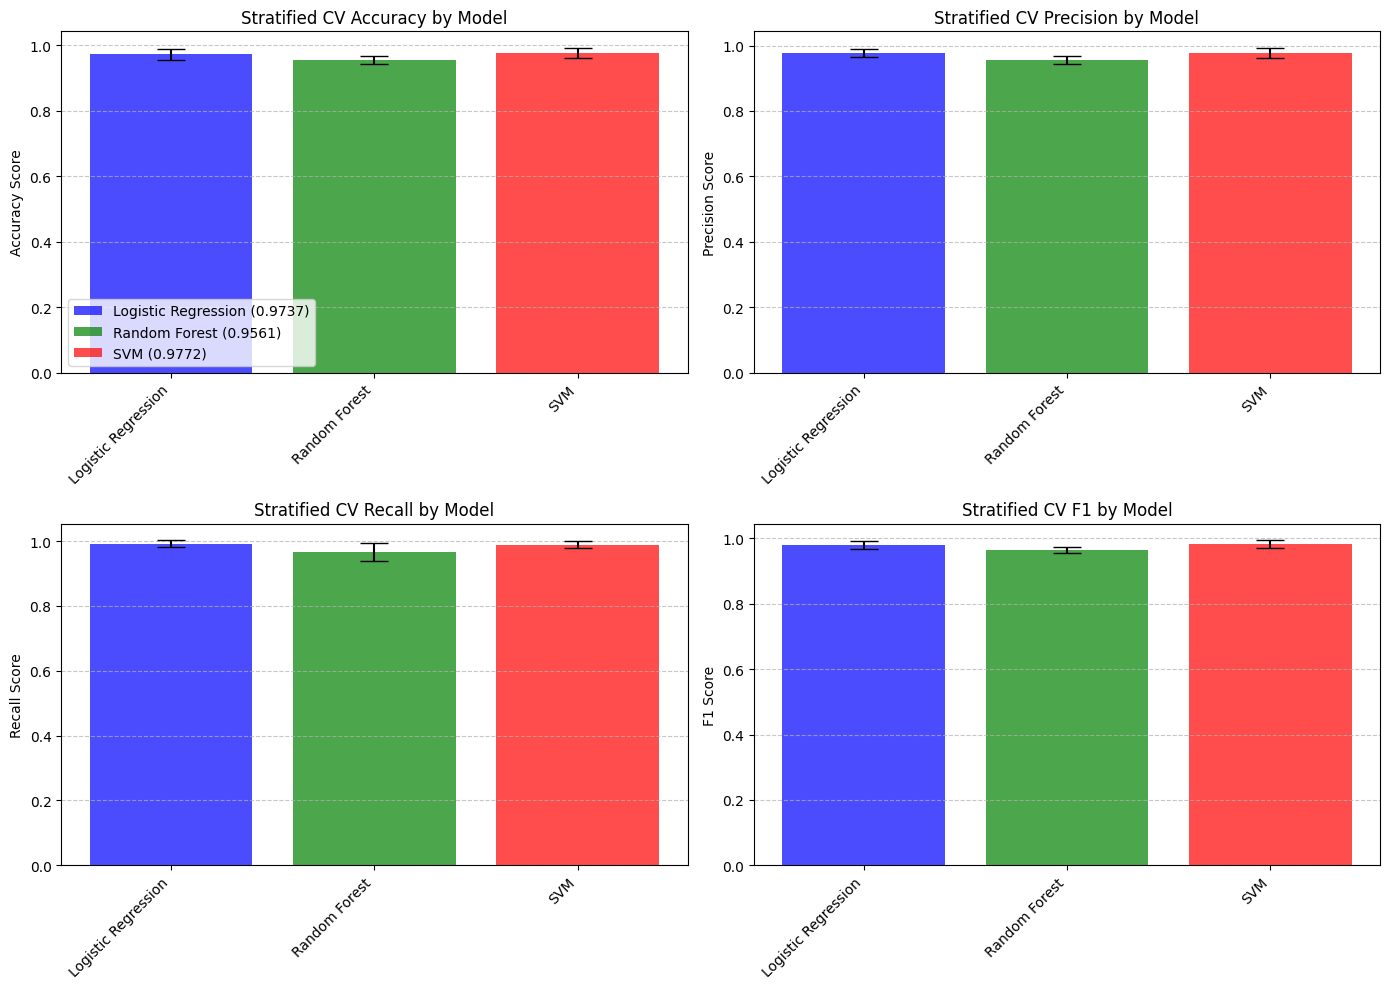

In [36]:
# Plot the results
plot_stratified_cv_results(results)

In [37]:
# 4. Demonstrating why stratified k-fold is important
def compare_stratified_vs_regular_kfold(X, y, model, n_splits=5):
    """
    Compare regular KFold with StratifiedKFold to show the importance of stratification.
    """
    from sklearn.model_selection import KFold

    # Create fold objects
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Create a pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # Compare class distributions and performance
    print("\nComparing Regular KFold vs StratifiedKFold:")

    # Arrays to store class ratios for each fold
    regular_class_ratios = []
    stratified_class_ratios = []

    # Arrays to store performance metrics
    regular_accuracy = []
    stratified_accuracy = []

    # Test regular KFold
    print("\nRegular KFold:")
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Get data for this fold
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Calculate class distributions
        train_class_dist = np.bincount(y_train) / len(y_train)
        test_class_dist = np.bincount(y_test) / len(y_test)

        # Store the minority class ratio (assuming binary classification)
        regular_class_ratios.append((train_class_dist[0], test_class_dist[0]))

        # Train and evaluate
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        regular_accuracy.append(acc)

        print(f"  Fold {fold+1}:")
        print(f"    Training set class distribution: Malignant {train_class_dist[0]:.2%}, Benign {train_class_dist[1]:.2%}")
        print(f"    Test set class distribution: Malignant {test_class_dist[0]:.2%}, Benign {test_class_dist[1]:.2%}")
        print(f"    Accuracy: {acc:.4f}")

    # Test StratifiedKFold
    print("\nStratifiedKFold:")
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        # Get data for this fold
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Calculate class distributions
        train_class_dist = np.bincount(y_train) / len(y_train)
        test_class_dist = np.bincount(y_test) / len(y_test)

        # Store the minority class ratio
        stratified_class_ratios.append((train_class_dist[0], test_class_dist[0]))

        # Train and evaluate
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        stratified_accuracy.append(acc)

        print(f"  Fold {fold+1}:")
        print(f"    Training set class distribution: Malignant {train_class_dist[0]:.2%}, Benign {train_class_dist[1]:.2%}")
        print(f"    Test set class distribution: Malignant {test_class_dist[0]:.2%}, Benign {test_class_dist[1]:.2%}")
        print(f"    Accuracy: {acc:.4f}")

    # Calculate statistics
    regular_class_ratios = np.array(regular_class_ratios)
    stratified_class_ratios = np.array(stratified_class_ratios)

    print("\nClass Distribution Statistics:")
    print(f"  Regular KFold - Std Dev of Malignant ratio in test sets: {np.std(regular_class_ratios[:, 1]):.4f}")
    print(f"  StratifiedKFold - Std Dev of Malignant ratio in test sets: {np.std(stratified_class_ratios[:, 1]):.4f}")

    print("\nPerformance Statistics:")
    print(f"  Regular KFold - Average Accuracy: {np.mean(regular_accuracy):.4f} (±{np.std(regular_accuracy):.4f})")
    print(f"  StratifiedKFold - Average Accuracy: {np.mean(stratified_accuracy):.4f} (±{np.std(stratified_accuracy):.4f})")

    # Visualize class distribution variability
    fig, ax = plt.subplots(figsize=(10, 6))

    x = np.arange(n_splits)
    width = 0.35

    ax.bar(x - width/2, regular_class_ratios[:, 1], width, label='Regular KFold', color='coral')
    ax.bar(x + width/2, stratified_class_ratios[:, 1], width, label='StratifiedKFold', color='skyblue')

    ax.set_xlabel('Fold')
    ax.set_ylabel('Malignant Class Ratio in Test Set')
    ax.set_title('Comparison of Class Distribution in Test Sets')
    ax.set_xticks(x)
    ax.set_xticklabels([f'Fold {i+1}' for i in range(n_splits)])
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Visualize performance variability
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(0, np.mean(regular_accuracy), yerr=np.std(regular_accuracy),
          capsize=10, color='coral', alpha=0.7, label='Regular KFold')
    ax.bar(1, np.mean(stratified_accuracy), yerr=np.std(stratified_accuracy),
          capsize=10, color='skyblue', alpha=0.7, label='StratifiedKFold')

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Regular KFold', 'StratifiedKFold'])
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Performance Comparison')
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()



Comparing Regular KFold vs StratifiedKFold:

Regular KFold:
  Fold 1:
    Training set class distribution: Malignant 37.14%, Benign 62.86%
    Test set class distribution: Malignant 37.72%, Benign 62.28%
    Accuracy: 0.9737
  Fold 2:
    Training set class distribution: Malignant 38.46%, Benign 61.54%
    Test set class distribution: Malignant 32.46%, Benign 67.54%
    Accuracy: 0.9825
  Fold 3:
    Training set class distribution: Malignant 37.14%, Benign 62.86%
    Test set class distribution: Malignant 37.72%, Benign 62.28%
    Accuracy: 0.9649
  Fold 4:
    Training set class distribution: Malignant 37.14%, Benign 62.86%
    Test set class distribution: Malignant 37.72%, Benign 62.28%
    Accuracy: 0.9912
  Fold 5:
    Training set class distribution: Malignant 36.40%, Benign 63.60%
    Test set class distribution: Malignant 40.71%, Benign 59.29%
    Accuracy: 0.9735

StratifiedKFold:
  Fold 1:
    Training set class distribution: Malignant 37.14%, Benign 62.86%
    Test set clas

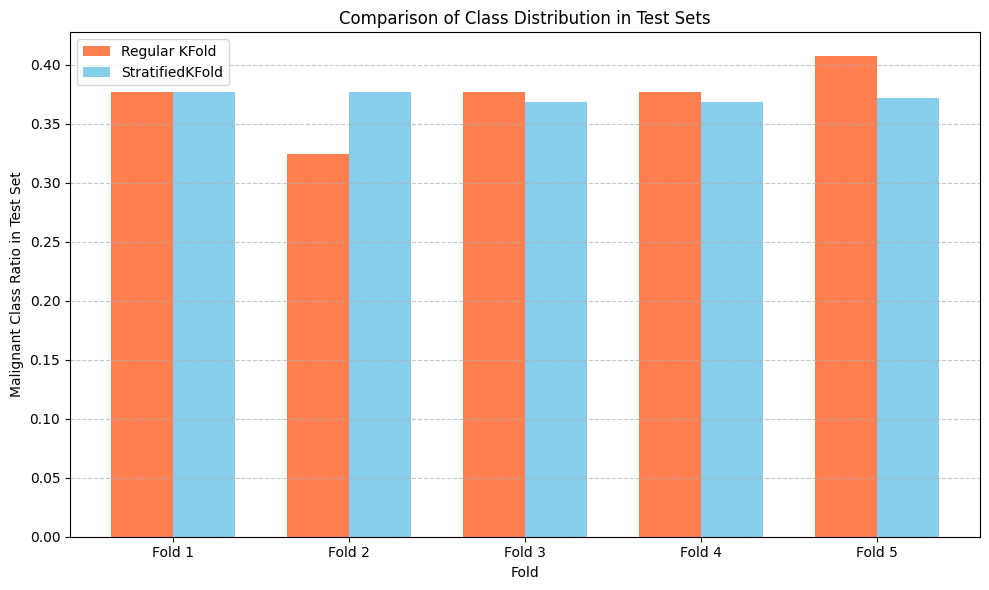

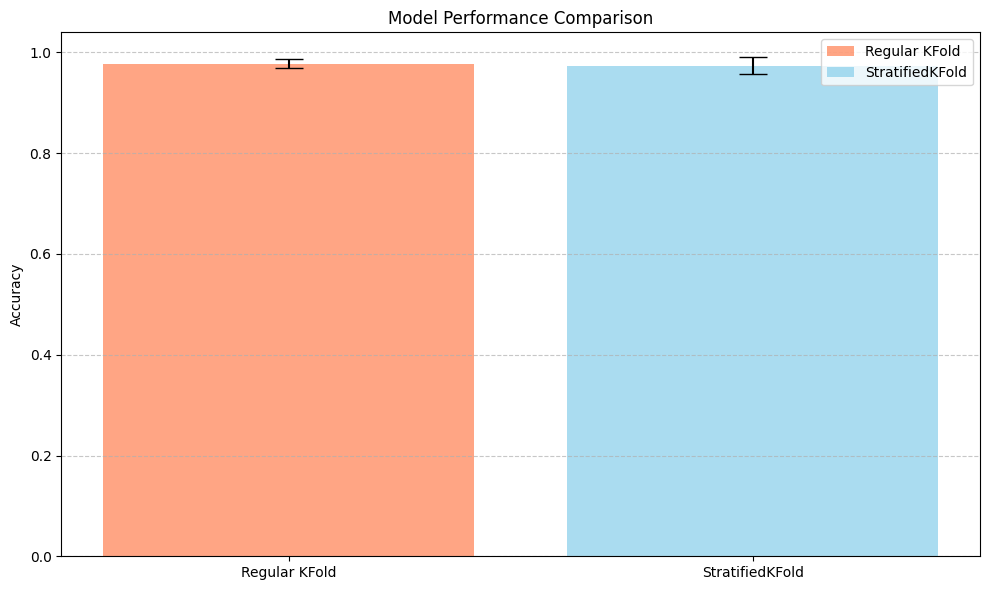

In [38]:
# Let's compare regular KFold vs StratifiedKFold
compare_stratified_vs_regular_kfold(X, y, LogisticRegression(max_iter=1000), n_splits=5)


In [39]:
# 5. Stratified K-fold with Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

In [40]:
def perform_hyperparameter_tuning(X, y, model, param_grid, n_splits=5):
    """
    Perform hyperparameter tuning using GridSearchCV with StratifiedKFold.
    """
    # Create the pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # Create the grid search object
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid={'model__' + k: v for k, v in param_grid.items()},
        cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    # Perform grid search
    print("\nPerforming grid search for hyperparameter tuning...")
    grid_search.fit(X, y)

    # Print results
    print("\nBest parameters:", grid_search.best_params_)
    print(f"Best accuracy: {grid_search.best_score_:.4f}")

    # Show top 5 parameter combinations
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df = results_df.sort_values('rank_test_score').head(5)

    print("\nTop 5 parameter combinations:")
    for i, row in results_df.iterrows():
        params = {k.replace('model__', ''): v for k, v in row['params'].items()}
        print(f"  {params} - Accuracy: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")

    return grid_search.best_estimator_

In [41]:
# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [42]:
# Perform hyperparameter tuning
best_rf_model = perform_hyperparameter_tuning(
    X, y,
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    n_splits=5
)



Performing grid search for hyperparameter tuning...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best parameters: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best accuracy: 0.9561

Top 5 parameter combinations:
  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100} - Accuracy: 0.9561 (±0.0123)
  {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100} - Accuracy: 0.9561 (±0.0123)
  {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100} - Accuracy: 0.9561 (±0.0123)
  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50} - Accuracy: 0.9543 (±0.0150)
  {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50} - Accuracy: 0.9543 (±0.0128)


In [43]:
# Finally, let's evaluate the best model on a held-out test set
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc

# Split the data into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create a pipeline with the best model
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', best_rf_model.named_steps['model'])
])

In [44]:
# Train the model
best_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Print classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)


Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



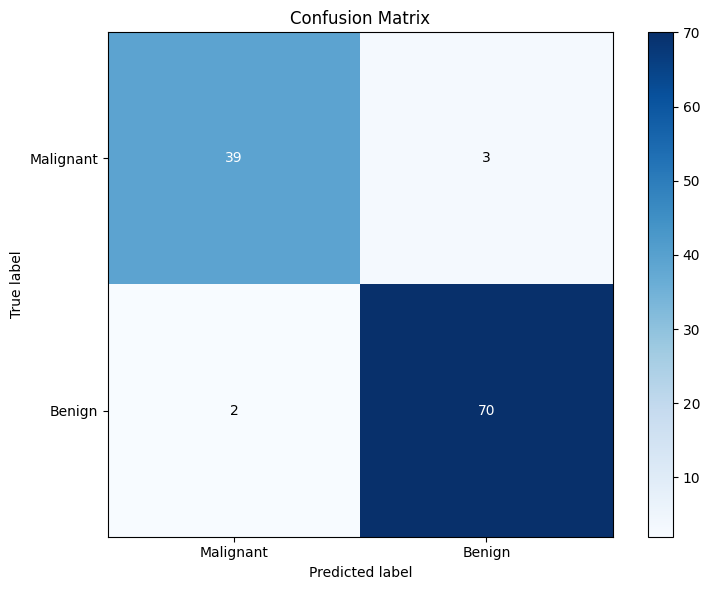

In [45]:
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['Malignant', 'Benign'],
       yticklabels=['Malignant', 'Benign'],
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Loop over data dimensions and create text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


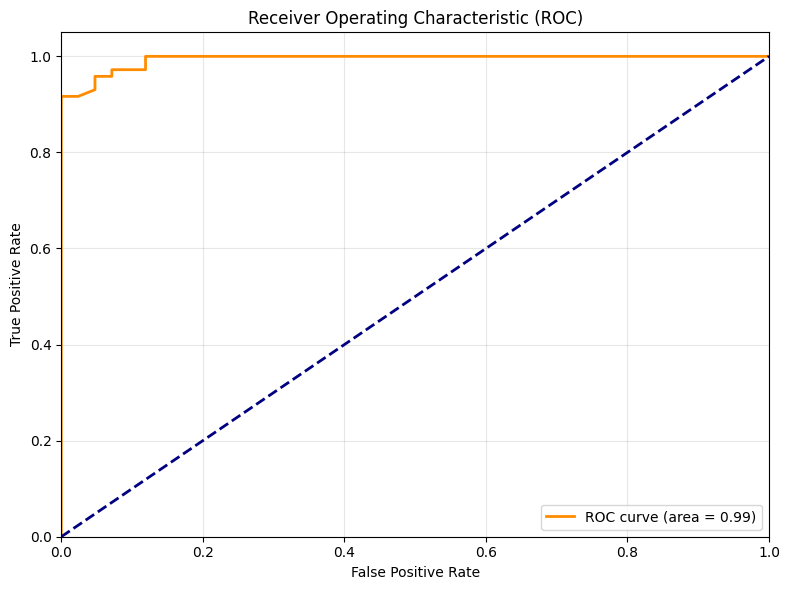


Stratified K-fold cross-validation workflow complete!


In [46]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nStratified K-fold cross-validation workflow complete!")